In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import pickle
torch.set_num_threads(1)
import time
import numpy as np
import torch
import scipy
import argparse
import sys
import matplotlib.pyplot as plt
import matplotlib
from arma import ode_system, solve_magi
from arma import matrix
import time
import pickle
from multiprocessing import Pool
import scipy.special as fun
torch.set_default_dtype(torch.double)

class Bessel(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inp, nu):
        ctx._nu = nu
        ctx.save_for_backward(inp)
        mat = fun.kv(nu, inp.detach().numpy())
        return (torch.from_numpy(np.array(mat)))

    @staticmethod
    def backward(ctx, grad_out):
        inp, = ctx.saved_tensors
        nu = ctx._nu
        grad_in = grad_out.numpy() * np.array(fun.kvp(nu, inp.detach().numpy()))
        return (torch.from_numpy(grad_in), None)


class generalMatern(object):

    # has_lengthscale = True

    def __init__(self, nu, lengthscale, **kwargs):
        # super(Matern,self).__init__(**kwargs)
        self.nu = nu
        self.log_lengthscale = torch.tensor(np.log(lengthscale))
        self.log_lengthscale.requires_grad_(True)

    def _set_lengthscale(self, lengthscale):
        self.log_lengthscale = torch.tensor(np.log(lengthscale))

    def lengthscale(self):
        return (torch.exp(self.log_lengthscale).item())

    def forward(self, x1, x2=None, **params):
        lengthscale = torch.exp(self.log_lengthscale)
        x1 = x1.squeeze()
        if x2 is None: x2 = x1
        r_ = (x1.reshape(-1, 1) - x2.reshape(1, -1)).abs()
        r_ = np.sqrt(2. * self.nu) * r_ / lengthscale
        # handle limit at 0, allows more efficient backprop
        r_ = torch.clamp(r_, min=1e-15)
        C_ = np.power(2, 1 - self.nu) * np.exp(-fun.loggamma(self.nu)) * torch.pow(r_, self.nu)
        mat = Bessel.apply(r_, self.nu)
        C_ = C_ * mat
        return (C_)

    def C(self, x1, x2=None):
        return (self.forward(x1, x2).detach())


def GPTrain(train_x, train_y, nu, lengthscale_lb=3., learning_rate=1e-6, noisy=True, max_iter=5, verbose=False,
            eps=1e-6):
    # preprocess input data
    n = train_x.size(0)
    # normalized x to 0 and 1
    x_range = [torch.min(train_x).item(), torch.max(train_x).item()]
    train_x = (train_x - x_range[0]) / (x_range[1] - x_range[0])
    #     train_x[0] = eps
    # set up kernel
    kernel = generalMatern(nu=nu, lengthscale=1.1 * lengthscale_lb / (x_range[1] - x_range[0]))
    # lambda = noise/outputscale
    log_lambda = torch.tensor(np.log(1e-2))
    log_lambda.requires_grad_(True)
    loglb_normalized = torch.log(torch.tensor(lengthscale_lb / (x_range[1] - x_range[0])))
    optimizer = torch.optim.LBFGS([kernel.log_lengthscale, log_lambda], lr=learning_rate)
    # training
    prev_loss = np.inf
    for i in range(max_iter):
        R = kernel.forward(train_x) + torch.exp(log_lambda) * torch.eye(n)
        e, v = torch.linalg.eigh(R)
        # e = e[:, 0]  # eigenvalues
        a = v.T @ torch.ones(n)
        b = v.T @ train_y
        mean = ((a / e).T @ b) / ((a / e).T @ a)
        d = v.T @ (train_y - mean)
        outputscale = 1. / n * (d / e).T @ d

        def closure():
            optimizer.zero_grad()
            R = kernel.forward(train_x) + torch.exp(log_lambda) * torch.eye(n)
            e, v = torch.linalg.eigh(R)
            # e = e[:, 0]  # eigenvalues
            a = v.T @ torch.ones(n)
            b = v.T @ train_y
            mean = ((a / e).T @ b) / ((a / e).T @ a)
            d = v.T @ (train_y - mean)
            outputscale = 1. / n * (d / e).T @ d
            loss = torch.log(outputscale) + torch.mean(torch.log(e))
            tmp0 = torch.clamp(kernel.log_lengthscale, max=0.)
            loss = loss + 1e3 * torch.sum(torch.square(kernel.log_lengthscale - tmp0))
            tmp = torch.clamp(kernel.log_lengthscale, min=loglb_normalized)
            loss = loss + 1e3 * torch.sum(torch.square(kernel.log_lengthscale - tmp))
            tmp2 = torch.clamp(log_lambda, min=np.log(1e-6))
            loss = loss + 1e3 * torch.sum(torch.square(log_lambda - tmp2))
            loss.backward()
            return loss

        optimizer.step(closure)

    R = kernel.forward(train_x) + torch.exp(log_lambda) * torch.eye(n)
    Rinv = torch.inverse(R)
    ones = torch.ones(n)
    mean = ((ones.T @ Rinv @ train_y) / (ones.T @ Rinv @ ones)).item()
    outputscale = (1 / n * (train_y - mean).T @ Rinv @ (train_y - mean)).item()
    noisescale = outputscale * torch.exp(log_lambda).item()
    return outputscale

def gen_data(alpha, beta, delta, gamma, days, obs_per_day, state0=[3., 1.], linspace=1000, noise=0.02, seed=7):
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]
    np.random.seed(seed)
    states *= np.random.normal(1, noise, states.shape)
    return np.log(states)

def fOde(theta, x, tvec):
    """
    description of ODE
    theta: list[4]
    return: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    Rdt = theta[0] - theta[1] * np.exp(fox)
    Fdt = theta[2] * np.exp(rabbit) - theta[3]
    return np.stack([Rdt, Fdt], axis=1)

def fOdeDx(theta, x, tvec):
    """
    returns ODE derivation of x given theta
    theta: list[4]
    x: array(n, 2)
    return: array(n, 2, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    resultDx = np.zeros(shape=[np.shape(x)[0], 2, 2])
    # [:, i, j]: jth equation derivative of the ith state
    # (0) / dR
    resultDx[:, 0, 0] = 0
    # (0) / dF
    resultDx[:, 1, 0] =  -theta[1] * np.exp(fox)
    # (1) / dR
    resultDx[:, 0, 1] = theta[2] * np.exp(rabbit)
    # (1) / dF
    resultDx[:, 1, 1] = 0
    return resultDx

def fOdeDtheta(theta, x, tvec):
    """
    returns ODE derivation of theta given x
    theta: list[4]
    x: array(n, 2)
    return: array(n, 4, 2)
    """
    resultDtheta = np.zeros(shape=[np.shape(x)[0], 4, 2])
    # [:, i, j]: jth equation derivative of the ith theta
    rabbit = x[:, 0]
    fox = x[:, 1]
    # (0) / 0
    resultDtheta[:, 0, 0] = 1.
    # (0) / 1
    resultDtheta[:, 1, 0] = -np.exp(fox)
    # (1) / 2
    resultDtheta[:, 2, 1] = np.exp(rabbit)
    # (1) / 3
    resultDtheta[:, 3, 1] = -1.
    return resultDtheta

def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])


# Construct theta series
def calibration_construct(vals, occurence_times_2):
    ls = []
    for idx in range(len(occurence_times_2)):
        for repeat_num in range(occurence_times_2[idx]):
            ls.append(vals[idx])
    return torch.cat(ls, axis=0)


def fOdeTorch(theta, x, constant_param_ls):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    Rdt = theta[:, 0] - constant_param_ls[0] * torch.exp(fox)
    Fdt = constant_param_ls[1] * torch.exp(rabbit) - theta[:, 1]
    return torch.stack([Rdt, Fdt], axis=1)



def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                     priorTemperature, bound=None):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[0][2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0][0]
    #  prior distriobution of X-
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0)
    for i in range(pdimension):
        res[i, 2] /= priorTemperature[i][1]
    if bound:
        extra_loss = torch.tensor([0.])
        for i in range(len(time_constant_param_ls)):
            extra_loss -= 1e20 * torch.square(time_constant_param_ls[i]-torch.clamp(time_constant_param_ls[i], min=bound[i].item() - 0.0001))
            extra_loss -= 1e20 * torch.square(time_constant_param_ls[i]-torch.clamp(time_constant_param_ls[i], max=bound[i].item() + 0.0001))
        return torch.sum(res) + torch.sum(extra_loss), res.detach().numpy()
    return torch.sum(res), res.detach().numpy()


def construct_kernel(dimension, covAllDimensions):
    PyList = []
    for each_gpcov in covAllDimensions:
        p_K = np.array(each_gpcov.mphi) @ np.array(each_gpcov.C)
        K_pp = np.array(each_gpcov.Kphi) - p_K @ np.array(each_gpcov.Cinv) @ p_K
        Cinv_tmp = np.linalg.pinv(np.array(each_gpcov.C)[:dimension, :dimension], hermitian=True)
        mphi_tmp = p_K[:dimension, :dimension] @ Cinv_tmp
        K_tmp = K_pp[:dimension, :dimension] + p_K[:dimension, :dimension] @ Cinv_tmp @ p_K[:dimension, :dimension]
        Kinv_tmp = np.linalg.pinv(K_tmp, hermitian=True)
        each_pycov = dict(
        Cinv=torch.tensor(Cinv_tmp),
        Kinv=torch.tensor(Kinv_tmp),
        mphi=torch.tensor(mphi_tmp),
    )
        PyList.append(each_pycov)
    return PyList


# def main_func(random_idx):
random_idx = 1
n_batch = 100
batch_size = 12
np.random.seed(random_idx)
cp_val = np.random.binomial(1, 0.08, n_batch)
cp_series = np.zeros(0)
for i in range(n_batch):
    if cp_val[i] == 0:
        cp_series = np.concatenate((cp_series, np.zeros(batch_size)), axis=None)
    else:
        np.random.seed(i)
        new_series = np.random.multinomial(1, [1/batch_size] * batch_size)
        cp_series = np.concatenate((cp_series, new_series), axis=None)

# construct gamma series
for i in range(len(cp_series)):
    if cp_series[i]:
        for j in range(min(i+1, len(cp_series)-1), min(len(cp_series)-1, i+60)):
            cp_series[j] = 0
discretization=1
obs_per_day=12
days = 5
total_days = int(days + n_batch * batch_size / obs_per_day)
alpha0 = 0.6
beta0 = 0.75 
delta0 = 1. 
# 
MAGI_iter = 15001
gamma_ls = [0.6, 1.0]
gamma = 0.6 * np.ones(12000 * days)
label = 0
for i in range(n_batch * batch_size):
    if cp_series[i]:
        label = 1-label
    val_tmp = gamma_ls[label]
    gamma = np.concatenate((gamma, val_tmp * np.ones(1000)))  
#     print(gamma.shape)
yobs_np = gen_data(alpha0, beta0, delta0, gamma, total_days, obs_per_day)
#     cp_series
#     plt.plot(yobs_np)
#     plt.plot(gamma[::1000])

discretization = 1
obs_per_day = 12 
days = 5
theta_lowerbound=np.array([0., 0., 0., 0.])
theta_upperbound=np.array([np.inf, np.inf, np.inf, np.inf])
param_names = ['alpha', 'beta', 'delta', 'gamma']
is_time_varying=[False, False, False, True] 
use_trajectory='inferred'
learning_rate=np.array([1e-4, 1e-3, 1e-5])
n_iter = [1501, 200000, 15000, 200000]

yobs = yobs_np[:60]
start_time = time.time()
nobs, p_dim = yobs.shape[0], yobs.shape[1]
n_points = nobs * discretization
theta_dim = theta_lowerbound.shape[0]
d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
for i in range(n_points):
    for j in range(n_points):
        if i > j:
            d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
        else:
            d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                         thetaLowerBound=theta_lowerbound,
                         thetaUpperBound=theta_upperbound)
tvecObs = np.arange(0, days, 1. / obs_per_day)
tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
yFull = np.ndarray([n_points, p_dim])
yFull.fill(np.nan)
yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
xInitExogenous = np.zeros_like(yFull)
# interpolate: find the ydata of tvecFull given observations
for i in range(p_dim):
    xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
# First stage: use MAGI package to optimize theta as constant
result = solve_magi(
    yFull,
    Ode_system,
    tvecFull,
    sigmaExogenous=np.array([]),
    phiExogenous=np.array([[]]),
    xInitExogenous=xInitExogenous,
    thetaInitExogenous=np.array([]),
    muExogenous=np.array([[]]),
    dotmuExogenous=np.array([[]]),
    priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
    priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
    priorTemperatureObs=1.0,
    kernel="generalMatern",
    nstepsHmc=100,
    burninRatioHmc=0.5,
    niterHmc=n_iter[0],
    stepSizeFactorHmc=0.01,
    nEpoch=1,
    bandSize=40,
    useFrequencyBasedPrior=True,
    useBand=False,
    useMean=False,
    useScalerSigma=False,
    useFixedSigma=False,
    verbose=True)
samplesCpp = result['samplesCpp']
llikId = 0
xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
# dimension of theta
thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
burnin = int(n_iter[0] * 0.5)
xsampled = samplesCpp[xId, (burnin + 1):]
xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
CovAllDimensionsPyList = []
thetaSampled = samplesCpp[thetaId, (burnin + 1):]
inferred_theta = np.mean(thetaSampled, axis=-1)
sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
inferred_sigma = np.mean(sigmaSampled, axis=-1)
inferred_trajectory = np.mean(xsampled, axis=-1)
for each_gpcov in result['result_solved'].covAllDimensions:
    each_pycov = dict(
        Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
        Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
        mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
    )
    CovAllDimensionsPyList.append(each_pycov)

batch_size = 1
n_batch = 1000
regret_length = 12
torch.set_default_dtype(torch.double)    
is_time_varying=[True, False, False, True] 
result_ls = []
cpd_ls = []
latentx_ls = []
h0_x_ls= []
h1_x_ls= []
psi_ls = []
indicator_ls = []
history_value = torch.stack([inferred_theta[0] * torch.ones(days * obs_per_day),
                             inferred_theta[3] * torch.ones(days * obs_per_day)], axis=1) # size: tensor[60, 3]
history_indicator = np.zeros(len(history_value))
init_scale = np.zeros(yobs_np.shape[1])
for EachDim in range(yobs_np.shape[1]):
    initial_scale = GPTrain(torch.tensor(np.arange(0., 5., 1/12)),torch.tensor(yobs_np[:60])[:, EachDim], 2.01)
    print(initial_scale)
    init_scale[EachDim] = initial_scale            
sigma_torch = torch.tensor(inferred_sigma, dtype=torch.double)
time_constant_param_ls = [] # List[tensor[1], tensor[1], tensor[1], tensor[1]]
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == False:
        param_name = param_names[thetaEachDim]
        globals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double) # , requires_grad=True
        time_constant_param_ls.append(eval(param_name))
# for each new batch
# new coming data: (EachBatch+1) * batch_size + days * obs_per_day)+regret_length             
kernel_size = 60
for EachBatch in range(n_batch):
    print('Batch ' + str(EachBatch))
    previous_psi = []
    for each in time_constant_param_ls:
        previous_psi.append(each.detach().clone())
    print(previous_psi)
    start_idx = int(EachBatch * batch_size)+regret_length
    end_idx = int(EachBatch * batch_size + days * obs_per_day)+regret_length
    # each time update one step
    history_indicator = np.concatenate([history_indicator[1:], np.array([history_indicator[-1]])])
    history_value = torch.cat((history_value[1:], history_value[-1].reshape(1, -1)))
    if kernel_size < 60:
        # update kernel
        print('kernel_size: ', kernel_size)
        yobs = yobs_np[end_idx - kernel_size:end_idx]
        tmp_CovAllDimensionsPyList = construct_kernel(kernel_size, result['result_solved'].covAllDimensions)
        window_scale = np.zeros(yobs.shape[1])
        for EachDim in range(yobs.shape[1]):
            scale = GPTrain(torch.tensor(np.linspace(1/12, kernel_size/12, kernel_size)),torch.tensor(yobs)[:, EachDim], 2.01)
            window_scale[EachDim] = scale
        ydata = torch.from_numpy(yobs).double()
        priorTemperature = torch.tensor([[1, max(window_scale[0] / init_scale[0], 0.1), 1], 
                                         [1, max(window_scale[1] / init_scale[1], 0.1), 1]])
        print('Temperature: ', priorTemperature)
        cur_loss = np.inf
        tmp_occurence_times = np.array([kernel_size, 0])
        new_construct_vals = [torch.tensor([history_value[-1].numpy()], requires_grad=True), torch.tensor([history_value[-1].numpy()], requires_grad=True)]
        print('new_construct_vals: ', new_construct_vals)
        print('tmp_occurence_times: ', tmp_occurence_times)
        lik_ls = np.zeros(min(kernel_size, regret_length)+1)
        theta_ls = []
        truncate_pointwise_xlatent_torch_tmp = torch.tensor(ydata, requires_grad=True, dtype=torch.double)
        # try every time stamp
        for EachIter in range(min(kernel_size, regret_length) +1):
            # if change point exists in the last 12 observations, label as no 
            print(EachIter, tmp_occurence_times)
            pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp]+ new_construct_vals, lr=1e-4)  #  , weight_decay = 1.0
            pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
            cur_loss_tmp = np.inf
            for epoch in range(100000):
                pointwise_optimizer.zero_grad()
                # compute loss function
                new_theta = calibration_construct(new_construct_vals, tmp_occurence_times)
                llik, res = pointwisethetasigmallikTorch(truncate_pointwise_xlatent_torch_tmp, new_theta, time_constant_param_ls, sigma_torch, 
                                             ydata, tmp_CovAllDimensionsPyList, fOdeTorch, priorTemperature, previous_psi)
                new_loss = -llik
                if epoch % 1000 == 0:
#                         print(epoch, new_loss.item())
                    diff = new_loss.item() - cur_loss_tmp
                    if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
                        break
                    cur_loss_tmp = new_loss.item()
                new_loss.backward()
                pointwise_optimizer.step()
                pointwise_lr_scheduler.step()
            lik_ls[EachIter] = llik.item()
            print(res)
            theta_ls.append(new_theta.detach().clone())
            tmp_occurence_times[-2] -= 1
            tmp_occurence_times[-1] += 1
        print(lik_ls)
        print('time_constant_param_ls', time_constant_param_ls)
        # update history of gamma
        # change point not detected
        if max(lik_ls) - lik_ls[0] <= 50.:
            # update history
            print('No change point!')
            result_ls.append(theta_ls[0].clone())
    #         print('accepted_theta: ', accepted_theta)
            kernel_size += 1
        else:
            idx = np.argmax(lik_ls)
            print('Change point: CPD alarm! ', end_idx - idx)
            cpd_ls.append(end_idx - idx)
            result_ls.append(theta_ls[idx].clone())
            kernel_size = 2
        continue

    print('Final kernel size: ', kernel_size)
    # y[12:72]
    yobs = yobs_np[end_idx-kernel_size:end_idx]
    window_scale = np.zeros(yobs.shape[1])
    for EachDim in range(yobs.shape[1]):
        scale = GPTrain(torch.tensor(np.arange(0., 5., 1/12)),torch.tensor(yobs)[:, EachDim], 2.01)
        window_scale[EachDim] = scale
    ydata = torch.from_numpy(yobs).double()
    priorTemperature = torch.tensor([[1, max(window_scale[0] / init_scale[0], 0.1), 1], 
                                     [1, max(window_scale[1] / init_scale[1], 0.1), 1]])
    print('Temperature: ', priorTemperature)
    cur_loss = np.inf
    occurence_times = np.array([regret_length, 0])
    tmp_history_indicator = history_indicator[:days * obs_per_day-regret_length]
    splits = np.split(history_value[:days * obs_per_day-regret_length].numpy(),np.where(np.diff(tmp_history_indicator))[0]+1)
#     print('Initial splits: ', splits)
    tmp = [len(i) for i in splits]
    tmp_occurence_times = np.array(tmp + [regret_length])
    new_construct_vals = [torch.tensor([EachSplit[0]], requires_grad=True) for EachSplit in splits] + [torch.tensor([history_value[-1].numpy()], requires_grad=True)]
    print('new_construct_vals: ', new_construct_vals)
    print('tmp_occurence_times: ', tmp_occurence_times)
    lik_ls = np.zeros(regret_length+1)
    theta_ls = []
    truncate_pointwise_xlatent_torch_tmp = torch.tensor(ydata, requires_grad=True, dtype=torch.double)
    # try every time stamp
    for EachIter in range(regret_length+1):
        # if change point exists in the last 12 observations, label as no 
        print(EachIter, tmp_occurence_times)
        pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp]+ new_construct_vals + time_constant_param_ls, lr=1e-4)  #  , weight_decay = 1.0
        pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
        cur_loss_tmp = np.inf
        for epoch in range(100000):
            pointwise_optimizer.zero_grad()
            # compute loss function
            new_theta = calibration_construct(new_construct_vals, tmp_occurence_times)
            llik, res = pointwisethetasigmallikTorch(truncate_pointwise_xlatent_torch_tmp, new_theta, time_constant_param_ls, sigma_torch, 
                                         ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature, previous_psi)
            new_loss = -llik
            if epoch % 1000 == 0:
#                 print(epoch, new_loss.item())
                diff = new_loss.item() - cur_loss_tmp
                if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
                    break
                cur_loss_tmp = new_loss.item()
            new_loss.backward()
            pointwise_optimizer.step()
            pointwise_lr_scheduler.step()
        lik_ls[EachIter] = llik.item()
        theta_ls.append(new_theta.detach().clone() )
        print(res)
        print('final construct vals: ', new_construct_vals)
        tmp_occurence_times[-2] += 1
        tmp_occurence_times[-1] -= 1

    lik_ls = np.flip(lik_ls)
    theta_ls.reverse()
    print(lik_ls)
    print('time_constant_param_ls', time_constant_param_ls)
    # update history of gamma
    # change point not detected
    if max(lik_ls) - lik_ls[0] <= 50.:
        # update history
        print('No change point!')
        accepted_theta = theta_ls[0].detach().clone() # size: tensor([96])
        accepted_theta_np = accepted_theta.numpy() # size: tensor([96])
#         print('accepted_theta: ', accepted_theta)
        for i in range(1, days * obs_per_day):
            if np.sum(np.abs(accepted_theta_np[i] - accepted_theta_np[i-1])) < 1e-3:
                history_indicator[i] = history_indicator[i-1]
            else:
                history_indicator[i] = 1 - history_indicator[i-1]   
        history_value = accepted_theta.clone()
#         print('history value: ', history_value)
        result_ls.append(history_value)
        indicator_ls.append(history_indicator)
        latentx_ls.append(truncate_pointwise_xlatent_torch_tmp)


    # change point detected
    else:     
        idx = np.argmax(lik_ls)
        print('Change point: ', end_idx-idx)
        cpd_ls.append(end_idx-idx)
        # update history
        accepted_theta = theta_ls[np.argmax(lik_ls)].detach().clone()
        accepted_theta_np = accepted_theta.numpy()
#         print('accepted_theta: ', accepted_theta)
        for i in range(1, days * obs_per_day):
            if np.sum(np.abs(accepted_theta_np[i] - accepted_theta_np[i-1])) < 1e-3:
                history_indicator[i] = history_indicator[i-1]
            else:
                history_indicator[i] = 1 - history_indicator[i-1]   
        history_value = accepted_theta.detach().clone()
        indicator_ls.append(history_indicator)
        result_ls.append(history_value.clone())
        latentx_ls.append(truncate_pointwise_xlatent_torch_tmp)
        psi_to_save = []
        for EachPsi in time_constant_param_ls:
            psi_to_save.append(EachPsi.detach().clone())
        psi_ls.append(psi_to_save)
        kernel_size = 2

pickle.dump(cpd_ls, open('change-point-'+ str(random_idx) + '.pkl', "wb" ))
pickle.dump(result_ls, open('new-result-'+ str(random_idx) + '.pkl', "wb" ))
    
    
# if __name__ ==  '__main__': 
#     torch.set_num_threads(1)
#     pool = Pool(processes=100)
#     results = pool.map(main_func, range(1))
#     pool.close()
#     pool.join()

/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


0.6253925196423495
0.5067824736203468
Batch 0
[tensor([0.7554]), tensor([0.9953])]
Final kernel size:  60
Temperature:  tensor([[1.0000, 0.8044, 1.0000],
        [1.0000, 0.2484, 1.0000]])
new_construct_vals:  [tensor([[0.6083, 0.5979]], requires_grad=True), tensor([[0.6083, 0.5979]], requires_grad=True)]
tmp_occurence_times:  [48 12]
0 [48 12]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:544: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[ 2.06734808e+02 -1.59181933e-01 -6.25751410e+00]
 [ 2.03043625e+02 -3.13789107e-01 -6.22956575e+00]]
final construct vals:  [tensor([[0.6084, 0.5965]], requires_grad=True), tensor([[0.5752, 0.6160]], requires_grad=True)]
1 [49 11]
[[ 2.06819751e+02 -1.60803399e-01 -6.28086569e+00]
 [ 2.03032070e+02 -3.28341741e-01 -6.23332840e+00]]
final construct vals:  [tensor([[0.6079, 0.5966]], requires_grad=True), tensor([[0.5717, 0.6180]], requires_grad=True)]
2 [50 10]
[[ 2.06899017e+02 -1.81720811e-01 -6.29122803e+00]
 [ 2.03052894e+02 -3.24297374e-01 -6.26674168e+00]]
final construct vals:  [tensor([[0.6076, 0.5966]], requires_grad=True), tensor([[0.5676, 0.6206]], requires_grad=True)]
3 [51  9]
[[206.94646048  -0.21134876  -6.30273292]
 [203.03484797  -0.33216358  -6.28857894]]
final construct vals:  [tensor([[0.6070, 0.5967]], requires_grad=True), tensor([[0.5629, 0.6234]], requires_grad=True)]
4 [52  8]
[[206.95128633  -0.22616981  -6.3400074 ]
 [202.92863962  -0.34649832  -6.30253297]]
f

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:474: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[ 7.03567759e+00 -3.84577559e-05 -8.76417417e-01]
 [ 6.95439761e+00 -5.71867130e-02 -3.65595009e+01]]
1 [1 1]
[[ 6.99216918e+00 -5.95923501e-08 -8.31421404e-01]
 [ 6.99672031e+00 -9.45434697e-06 -3.65959883e+01]]
2 [0 2]
[[ 7.03526656e+00 -3.66327513e-05 -8.75958070e-01]
 [ 7.00300282e+00 -5.71489275e-02 -3.66018714e+01]]
[-23.5030683  -23.43852977 -23.49674568]
time_constant_param_ls [tensor([0.7529], requires_grad=True), tensor([1.0037], requires_grad=True)]
No change point!
Batch 259
[tensor([0.7529]), tensor([1.0037])]
kernel_size:  3
Temperature:  tensor([[1.0000, 0.1419, 1.0000],
        [1.0000, 0.1000, 1.0000]])
new_construct_vals:  [tensor([[0.6084, 0.8249]], requires_grad=True), tensor([[0.6084, 0.8249]], requires_grad=True)]
tmp_occurence_times:  [3 0]
0 [3 0]
[[ 1.00594954e+01 -2.77639657e-03 -6.48871033e-01]
 [ 1.06920178e+01 -3.06474657e-01 -3.69838067e+01]]
1 [2 1]
[[ 1.00044333e+01 -1.84175872e-04 -4.93993623e-01]
 [ 1.07376251e+01 -2.39502229e-01 -3.66084695e+01]]
2 [

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[ 2.09760487e+02 -1.80944863e-01 -6.30480216e+00]
 [ 2.03050729e+02 -2.34771167e-01 -2.59014646e+01]]
final construct vals:  [tensor([[0.6002, 0.9970]], requires_grad=True), tensor([[0.5945, 1.0227]], requires_grad=True)]
6 [54  6]
[[ 2.09755507e+02 -1.78521424e-01 -6.30690284e+00]
 [ 2.02947067e+02 -2.53975945e-01 -2.58858276e+01]]
final construct vals:  [tensor([[0.6002, 0.9972]], requires_grad=True), tensor([[0.5926, 1.0226]], requires_grad=True)]
7 [55  5]
[[ 2.09732415e+02 -1.80401984e-01 -6.29901137e+00]
 [ 2.02974329e+02 -2.69999786e-01 -2.59102832e+01]]
final construct vals:  [tensor([[0.6001, 0.9973]], requires_grad=True), tensor([[0.5922, 1.0262]], requires_grad=True)]
8 [56  4]
[[ 2.09712903e+02 -1.78763358e-01 -6.30064820e+00]
 [ 2.03100983e+02 -3.02574656e-01 -2.59636373e+01]]
final construct vals:  [tensor([[0.6000, 0.9974]], requires_grad=True), tensor([[0.5927, 1.0339]], requires_grad=True)]
9 [57  3]
[[ 2.09689154e+02 -1.78585756e-01 -6.29762790e+00]
 [ 2.03132832e+02

KeyboardInterrupt: 

In [3]:
ydata.shape

torch.Size([60, 2])

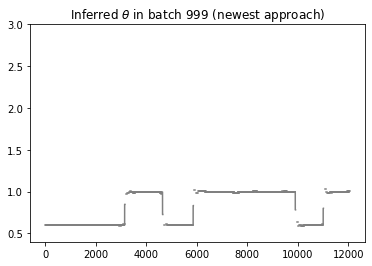

In [10]:
# plt.plot(gamma[::1000], label='truth')
for i in range(n_batch):
        
    plt.plot(np.arange(12 * i+72 - len(result_ls[i]), 12 * i + 72, 1), result_ls[i].numpy()[:, 1], c='grey', label=r' $\gamma$ (batch '+str(i) + ')')

    plt.title(r'Inferred $\theta$ in batch ' + str(i) + ' (newest approach)')
    plt.ylim(0.4, 3.0)
plt.show()

105
(1260000,)


Text(0.5, 0, 'time (year)')

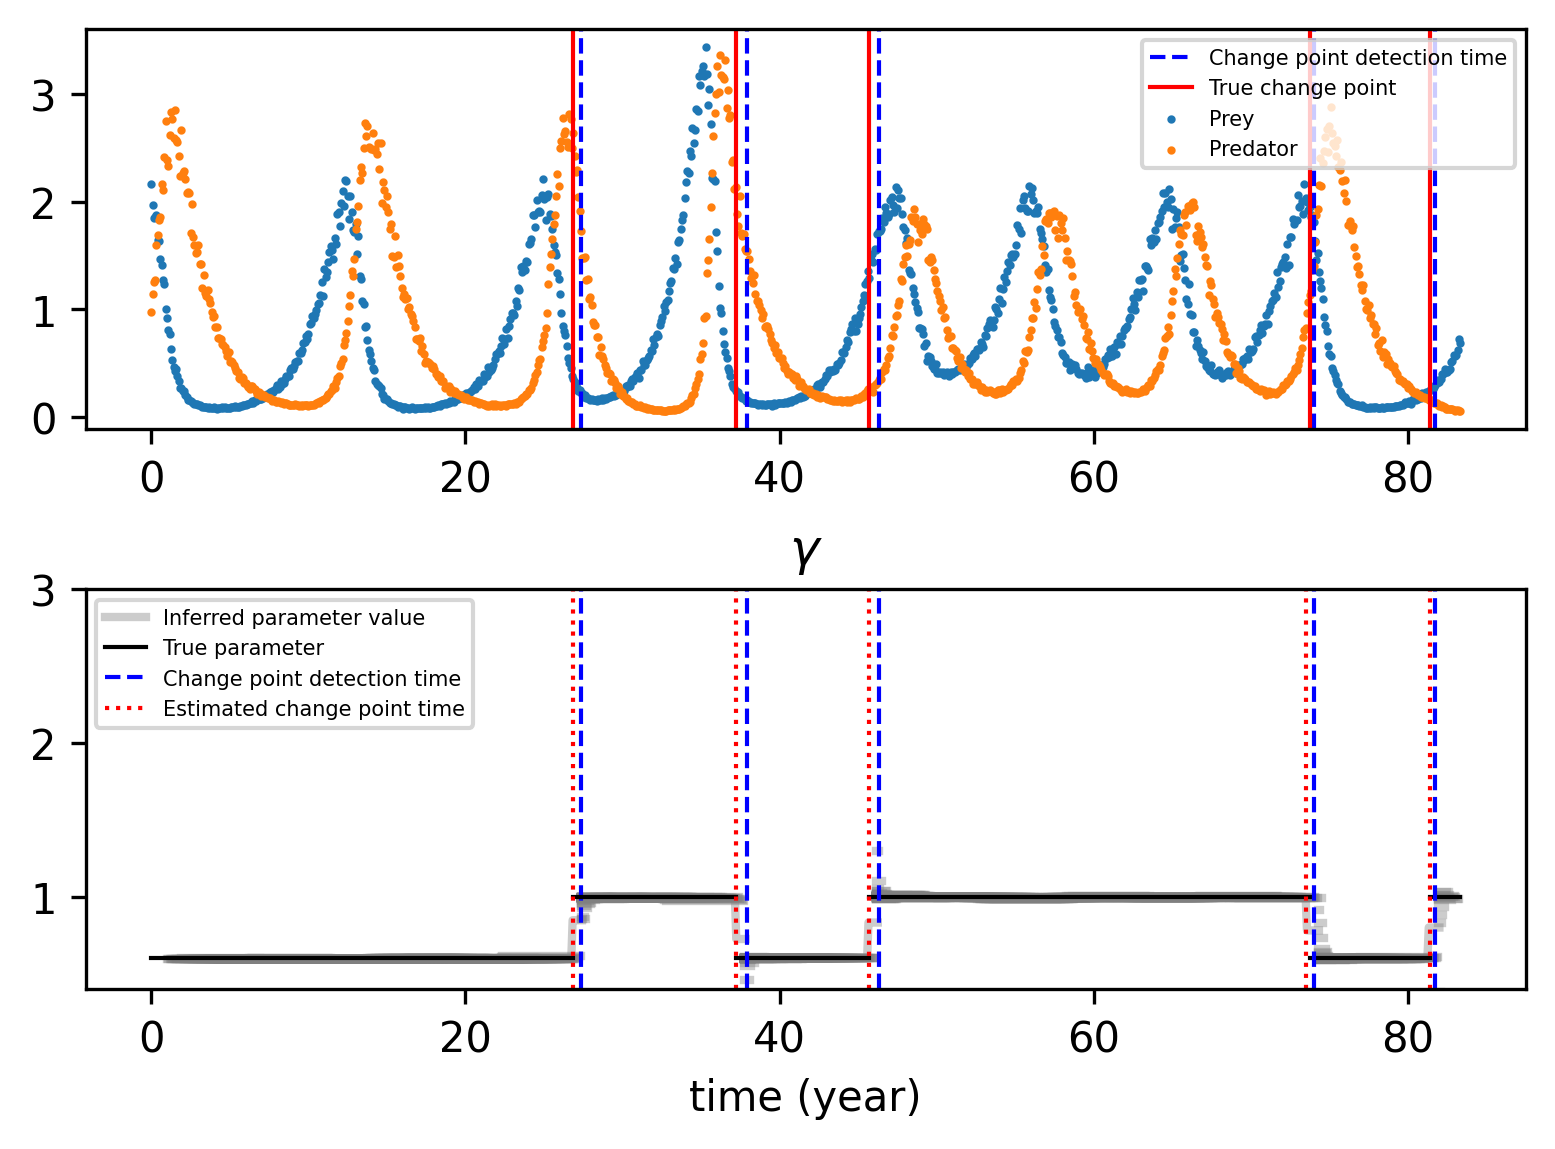

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import pickle
torch.set_num_threads(1)
import time
torch.set_default_dtype(torch.double)

def gen_data(alpha, beta, delta, gamma, days, obs_per_day, state0=[2., 1.], linspace=1000, noise=0.05, seed=7):
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]
    np.random.seed(seed)
    states *= np.random.normal(1, noise, states.shape)
    return np.log(states)

    
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
torch.set_num_threads(1)
n_batch = 100
batch_size = 12
np.random.seed(1)
cp_val = np.random.binomial(1, 0.08, n_batch)
cp_series = np.zeros(0)
for i in range(n_batch):
    if cp_val[i] == 0:
        cp_series = np.concatenate((cp_series, np.zeros(batch_size)), axis=None)
    else:
        np.random.seed(i)
        new_series = np.random.multinomial(1, [1/batch_size] * batch_size)
        cp_series = np.concatenate((cp_series, new_series), axis=None)
        
# construct gamma series
for i in range(len(cp_series)):
    if cp_series[i]:
        for j in range(i+1, min(len(cp_series), i+60)):
            cp_series[j] = 0
discretization=1
obs_per_day=12
days = 5
total_days = int(days + n_batch * batch_size / obs_per_day)
print(total_days)
alpha0 = 0.6
beta0 = 0.75 
delta0 = 1. 
# 
MAGI_iter = 15001
gamma_ls = [0.6, 1.0]
gamma = 0.6 * np.ones(12000 * days)
label = 0
for i in range(n_batch * batch_size):
    if cp_series[i]:
        label = 1-label
    val_tmp = gamma_ls[label]
    gamma = np.concatenate((gamma, val_tmp * np.ones(1000)))  

print(gamma.shape)
yobs_np = gen_data(alpha0, beta0, delta0, gamma, total_days, obs_per_day)
gamma0 = gamma[::1000][:1000]
plt.subplot(2, 1, 1)
plt.scatter(np.linspace(0, 1000/12, 1000), np.exp(yobs_np[:1000, 0]), s=1, label='Prey')
plt.scatter(np.linspace(0, 1000/12, 1000), np.exp(yobs_np[:1000, 1]), s=1, label='Predator')
plt.axvline(x = 328/12, color = 'b', linestyle = 'dashed', linewidth=1, label='Change point detection time')
plt.axvline(x = 455/12, color = 'b', linestyle = 'dashed', linewidth=1)
plt.axvline(x = 556/12, color = 'b', linestyle = 'dashed', linewidth=1)
plt.axvline(x = 888/12, color = 'b', linestyle = 'dashed', linewidth=1)
plt.axvline(x = 981/12, color = 'b', linestyle = 'dashed', linewidth=1)

plt.axvline(x = 322/12, color = 'r', linestyle = '-', linewidth=1, label='True change point')
plt.axvline(x = 447/12, color = 'r', linestyle = '-', linewidth=1)
plt.axvline(x = 548/12, color = 'r', linestyle = '-', linewidth=1)
plt.axvline(x = 885/12, color = 'r', linestyle = '-', linewidth=1)
plt.axvline(x = 977/12, color = 'r', linestyle = '-', linewidth=1)
plt.legend(fontsize=5)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.subplot(2, 1, 2)
plt.title(r'$\gamma$')
for i in range(927):
        
    plt.plot(np.linspace((i+72 - len(result_ls[i]))/12, (i + 72) / 12, len(result_ls[i])), result_ls[i].numpy()[:, 1], c='grey', alpha=0.4, linewidth=2)
    plt.ylim(0.4, 3.0)

i = 927    
plt.plot(np.linspace((i+72 - len(result_ls[i]))/12, (i + 72) / 12, len(result_ls[i])), result_ls[i].numpy()[:, 1], c='grey', alpha=0.4, linewidth=2, label = 'Inferred parameter value')
plt.plot(np.linspace(0, 322/12, 322), gamma0[:322], color='black', linewidth=1, label = 'True parameter')
plt.axvline(x = 328/12, color = 'b', linestyle = 'dashed', linewidth=1, label = 'Change point detection time')
plt.plot(np.linspace(322/12, 447/12, 125), gamma0[322:447], color='black', linewidth=1)
plt.plot(np.linspace(447/12, 548/12, 101), gamma0[447:548], color='black', linewidth=1)
plt.axvline(x = 455/12, color = 'b', linestyle = 'dashed', linewidth=1)
plt.plot(np.linspace(548/12, 885/12, 337), gamma0[548:885], color='black', linewidth=1)
plt.axvline(x = 556/12, color = 'b', linestyle = 'dashed', linewidth=1)
plt.plot(np.linspace(885/12, 977/12, 92), gamma0[885:977], color='black', linewidth=1)
plt.axvline(x = 888/12, color = 'b', linestyle = 'dashed', linewidth=1)
plt.plot(np.linspace(977/12, 1000/12, 23), gamma0[977:1000], color='black', linewidth=1)
plt.axvline(x = 981/12, color = 'b', linestyle = 'dashed', linewidth=1)

plt.axvline(x = 322/12, color = 'r', linestyle = 'dotted', linewidth=1, label = 'Estimated change point time')
plt.axvline(x = 447/12, color = 'r', linestyle = 'dotted', linewidth=1)
plt.axvline(x = 548/12, color = 'r', linestyle = 'dotted', linewidth=1)
plt.axvline(x = 882/12, color = 'r', linestyle = 'dotted', linewidth=1)
plt.axvline(x = 977/12, color = 'r', linestyle = 'dotted', linewidth=1)
plt.legend(fontsize=5)
plt.xlabel('time (year)')

In [33]:
result_ls

[tensor([[0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
         [0.6029, 0.5967],
 